# Artificial Intelligence  2 Assignment
## Peace Samuel, 121376141

Building an image classifier to  classify Butterflies(Monarch, Admiral, Painted Lady)

Steps:

- [x] Load in data (Completed)
- [x] Preprocess data (Completed)
- [x] Build a baseline model (Completed)
- [x] Load Pretrained model (Completed)
- [x] Train & evaluate models (Completed)
- [x] Save best model (Completed)
- [ ] make predictions with new images

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# from tensorflow.keras.applications import VGG16

## Dataset Connection

After obtaing 200 jpg images of each class, cleaning the data, and partitioning the dataset into three: train, val, test. Upload to Google Drive and mount the drive to the notebook.

In [2]:
#MOUNT GOOGLE DRIVE
#from google.colab import drive
#drive.mount('/content/drive')
base_dir = "./drive/My Drive/Colab Notebooks/"

In [3]:
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

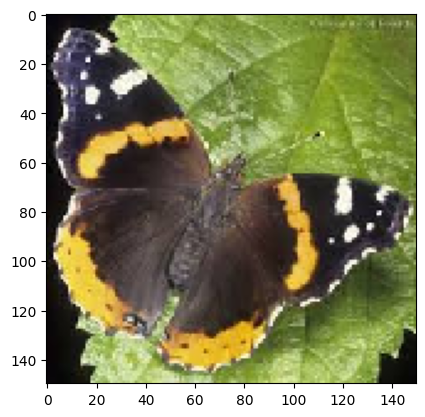

In [4]:
#check an image to check connection
train_admiral_dir = os.path.join(train_dir, "admiral_butterfly")
filenames = [os.path.join(train_admiral_dir, filename) for filename in os.listdir(train_admiral_dir)]

idx = 10
some_example = load_img(filenames[idx], target_size=(150,150))
plt.imshow(some_example)

## Data Preprocessing

- One-hot encoding (label_mode = categorical)
- Resize images (224, 224)
- Shuffle the data (default value is True)

In [5]:
train_dataset = image_dataset_from_directory(directory=train_dir, label_mode="categorical", image_size=(224, 224))
val_dataset = image_dataset_from_directory(directory=val_dir, label_mode="categorical", image_size=(224, 224))
test_dataset = image_dataset_from_directory(directory=test_dir, label_mode="categorical", image_size=(224, 224))

Found 150 files belonging to 3 classes.
Found 225 files belonging to 3 classes.
Found 225 files belonging to 3 classes.


## Build a Baseline Model

Before building my final transfer learning model, I will first build and train a basic convnet with few layers. This will act as a baseline model, it will allow me to see if the more complex model actually improves accuracy.

In [ ]:
#This is a basic convnet, just to act as a baseline, we hope to improve upon this
inputs = Input(shape=(224, 224, 3))
x = Rescaling(scale=1./255)(inputs)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
outputs = Dense(3, activation="softmax")(x)
convnet = Model(inputs, outputs)
convnet.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
convnet.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 109, 109, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 52, 52, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,604,771 (9.94 MB)

 Trainable params: 2,604,771 (9.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Train & Test the basic convnet
convnet_history = convnet.fit(train_dataset, epochs=30,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<Axes: >

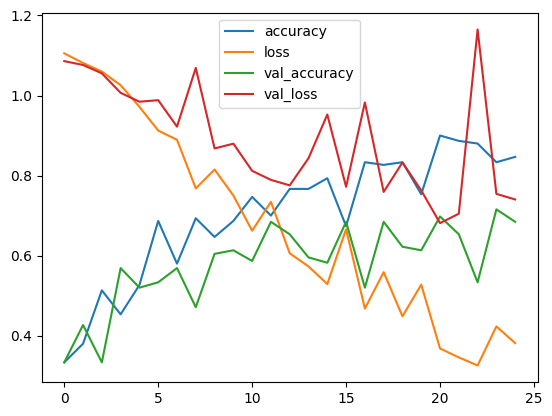

In [ ]:
pd.DataFrame(convnet_history.history).plot()

This first version of the baseline model seems to slightly overfit (performs well on the training but poorly on the validation), the performance isn't as good as I had hoped/expected (this may be due to the few layers, or the relatively small dataset)
I will try adding Dropout and Data Augmentation to this model to hopefully improve it some more.
- Data Augmentation: helps to increase diversity in a dataset (helpful since we have a small dataset)
- Dropout: helps with overfitting, acts as an ensemble

In [ ]:
#This is a basic convnet, just to act as a baseline, we hope to improve upon this
#Adding dropout & augmntation
inputs = Input(shape=(224, 224, 3))
x = RandomFlip(mode="horizontal")(inputs) #random horizontal flip
x = RandomRotation(factor=0.1)(x) #rotate images by up to 10%
x = RandomZoom(height_factor=(-0.2, 0.2))(x) #zoom in/out of images
x = RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
x = Rescaling(scale=1./255)(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x) #50% dropout rate
x = Dense(512, activation="relu")(x)
outputs = Dense(3, activation="softmax")(x)
convnet = Model(inputs, outputs)
convnet.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
convnet.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_3 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_3 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_1                 │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,604,771 (9.94 MB)

 Trainable params: 2,604,771 (9.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Train & Test the basic convnet with Dropout & Data Augmentation
convnet_history = convnet.fit(train_dataset, epochs=30,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<Axes: >

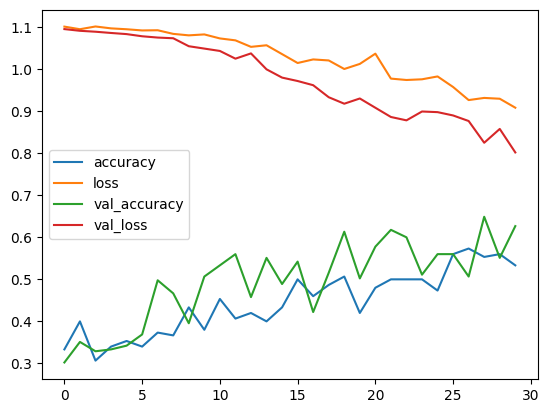

In [ ]:
pd.DataFrame(convnet_history.history).plot()

This has further improved the performance of the baseline model.

Now I will build and train a more advanced model using transfer learning, hoping to improve the accuracy.

## Load  & Build Pretrained Model

The pretrained model I chose to use is <b>ResNet50</b> for various reasons:
- ResNet is pretrained on a large dataset of images -> ImageNet (millions of images)
- Because of this it works well with a wide range of image classification tasks

I may also try to use ResNet18/34 or VGG16 (these are smaller, but maybe a simpler model may be sufficient), -> in the end  ResNet50 worked quite well

In [ ]:
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [ ]:
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = resnet50_base(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
outputs = Dense(3, activation="softmax")(x)
transfer_model = Model(inputs=inputs, outputs=outputs)

In [ ]:
#freeze layers in convolutional base
resnet50_base.trainable = False
transfer_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_21 (GetItem)     │ (None, 224, 224)       │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_22 (GetItem)     │ (None, 224, 224)       │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_23 (GetItem)     │ (None, 224, 224)       │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_7 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_21[0][0],     │
│                           │                        │                │ get_item_22[0][0],     │
│                           │                        │                │ get_item_23[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 5, 5, 32)       │        589,856 │ resnet50[4][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 2, 2, 32)       │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_11 (Flatten)      │ (None, 128)            │              0 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 3)              │            387 │ flatten_11[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,177,955 (92.23 MB)

 Trainable params: 24,071,715 (91.83 MB)

 Non-trainable params: 106,240 (415.00 KB)

In [ ]:
transfer_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
transfer_model_history = transfer_model.fit(train_dataset, epochs=30,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<Axes: >

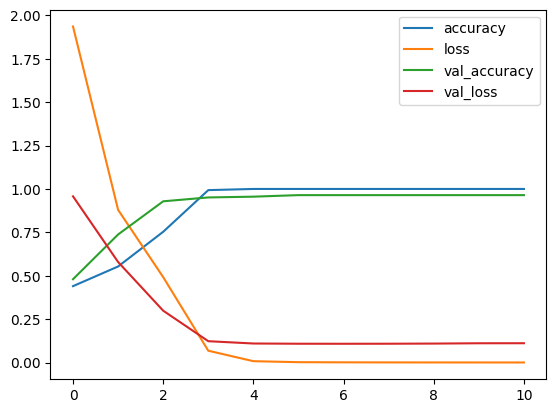

In [ ]:
pd.DataFrame(transfer_model_history.history).plot()

In order to improve the performance, I will try unfreezing some layers and continue training, (advised not to unfreeze layers for BatchNormalisation)
- This will allow the model to learn more fine-tuned features (improves performance for this specific task)

In [ ]:
for layer in resnet50_base.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [ ]:
transfer_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_21 (GetItem)     │ (None, 224, 224)       │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_22 (GetItem)     │ (None, 224, 224)       │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_23 (GetItem)     │ (None, 224, 224)       │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_7 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_21[0][0],     │
│                           │                        │                │ get_item_22[0][0],     │
│                           │                        │                │ get_item_23[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 5, 5, 32)       │        589,856 │ resnet50[4][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 2, 2, 32)       │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_11 (Flatten)      │ (None, 128)            │              0 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 3)              │            387 │ flatten_11[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 48,249,672 (184.06 MB)

 Trainable params: 24,071,715 (91.83 MB)

 Non-trainable params: 106,240 (415.00 KB)

 Optimizer params: 24,071,717 (91.83 MB)

In [ ]:
#recompile and resume training
transfer_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
transfer_model_history = transfer_model.fit(train_dataset, epochs=30,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<Axes: >

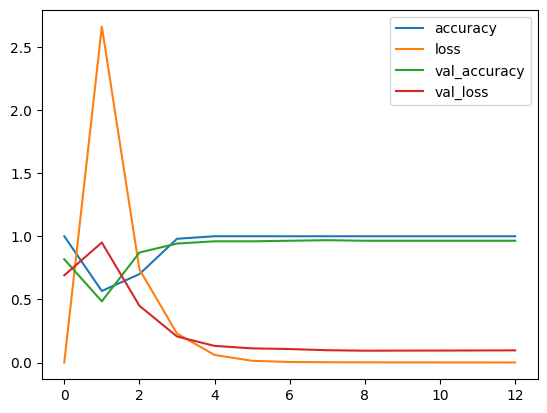

In [ ]:
pd.DataFrame(transfer_model_history.history).plot()

This model performs well, but as a final step I will try adding some data augementation and dropout, to see if this will have any effect on the accuracy.

This is simply out of curiosity, if it does not make any improvements i will stick with the original model.

In [ ]:
for layer in resnet50_base.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

inputs2 = Input(shape=(224, 224, 3))
x = RandomFlip(mode="horizontal")(inputs2) #random horizontal flip
x = RandomRotation(factor=0.1)(x) #rotate images by up to 10%
x = RandomZoom(height_factor=(-0.2, 0.2))(x) #zoom in/out of images
x = preprocess_input(x)
x = resnet50_base(x)
x = Flatten()(x)
x = Dropout(0.2)(x)  # 20% dropout rate
outputs2 = Dense(3, activation="softmax")(x)

transfer_model2 = Model(inputs=inputs2, outputs=outputs2)
transfer_model2.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
transfer_model2.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip_6             │ (None, 224, 224, 3)    │              0 │ input_layer_12[0][0]   │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation_6         │ (None, 224, 224, 3)    │              0 │ random_flip_6[0][0]    │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom_6             │ (None, 224, 224, 3)    │              0 │ random_rotation_6[0][… │
│ (RandomZoom)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_18 (GetItem)     │ (None, 224, 224)       │              0 │ random_zoom_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_19 (GetItem)     │ (None, 224, 224)       │              0 │ random_zoom_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_20 (GetItem)     │ (None, 224, 224)       │              0 │ random_zoom_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_6 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_18[0][0],     │
│                           │                        │                │ get_item_19[0][0],     │
│                           │                        │                │ get_item_20[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_10 (Flatten)      │ (None, 100352)         │              0 │ resnet50[3][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 100352)         │              0 │ flatten_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 3)              │        301,059 │ dropout_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,888,771 (91.13 MB)

 Trainable params: 23,782,531 (90.72 MB)

 Non-trainable params: 106,240 (415.00 KB)

In [ ]:
transfer_model_history2 = transfer_model2.fit(train_dataset, epochs=30,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<Axes: >

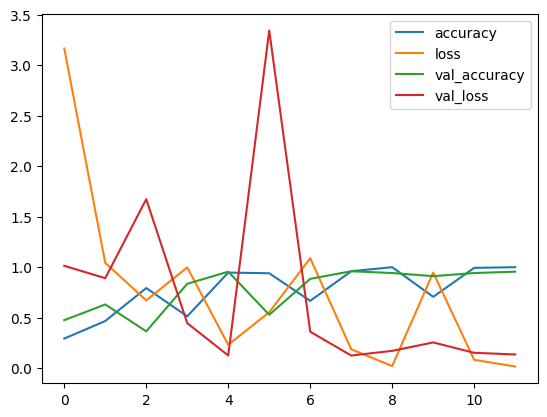

In [ ]:
pd.DataFrame(transfer_model_history2.history).plot()

It is clear that this has not improved the performace of the model.

The transfer learning model that does not contain any data augmentation or dropout layers performed better.

## TRY VGG16
I tried this pretrained base model, but since it did not perform as well as the ResNet50 model I decided not to use it in the final model.

<Axes: >

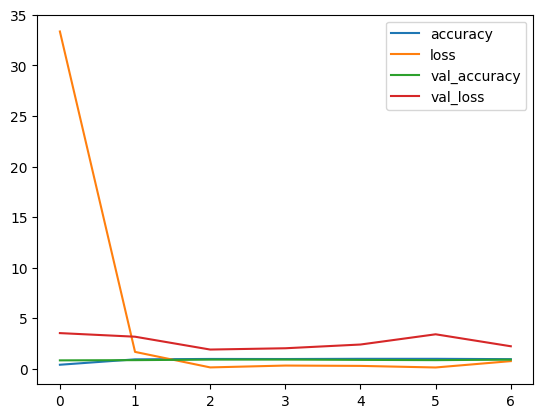

In [7]:
# import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow.keras import Model
# from tensorflow.keras.applications.vgg16 import VGG16


# # Load the VGG16 model, pre-trained on ImageNet data, without the top layer (classifier)
# base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# # Freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

# # Add custom layers on top of the pre-trained base
# x = layers.Flatten()(base_model.output)
# x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x) #50% dropout rate
# x = layers.Dense(3, activation='softmax')(x)

# # Create the new model
# model = Model(base_model.input, x)

# # Compile the model
# model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# # Train the model
# model_history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,epochs=30,
#     callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
#                 verbose=0
# )

# pd.DataFrame(model_history.history).plot()

The VGG16 model does not perform better than the ResNet50 model

## Test on test set

Test each model on the test set, choose and save the best model.

In [8]:
# VGG16 transfer learning model, Not an improvement from the ResNet50 model
# test_loss, test_acc = model.evaluate(test_dataset)
# test_acc

8/8 ━━━━━━━━━━━━━━━━━━━━ 108s 13s/step - accuracy: 0.8938 - loss: 2.4481


0.9066666960716248

In [ ]:
# original convnet
test_loss, test_acc = convnet.evaluate(test_dataset)
test_acc

8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 14s/step - accuracy: 0.5968 - loss: 0.7916


0.6000000238418579

In [ ]:
# transfer learning convnet with dropout & data augmentation
test_loss, test_acc = transfer_model2.evaluate(test_dataset)
test_acc

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.8892 - loss: 0.3069


0.8933333158493042

In [ ]:
# original transfer learning convnet BEST MODEL
test_loss, test_acc = transfer_model.evaluate(test_dataset)
test_acc

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.9599 - loss: 0.1082


0.9599999785423279

It is clear that the final model chosen, performs better than the baseline model.

## Save best model

In [ ]:
transfer_model.save(os.path.join(base_dir, "best_model.keras"))